# batch MCX sim

## setup

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 25 19:50:49 2025

@author: zhiguan wang
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pmcx
from scipy.optimize import curve_fit
from cv2 import resize
import cv2
import os
from tqdm import tqdm
from scipy.signal import fftconvolve
from torchvision import datasets, transforms
import torchvision
import torch
import collections
from torch.utils.data import DataLoader,Subset
import pickle
import json

from datetime import datetime

import ipywidgets as widgets
from IPython.display import display

# create an output widget for logging
disp_region = widgets.Output(layout={'border': '1px solid black', 'height': '800px', 'overflow_y': 'scroll'})

## get dataset

In [2]:
ROOT = "F:/OneDrive/foam_imaging_project/pmcx_foam/MNIST_img_dataset"  # root fold for the data       
SPLIT = "byclass"       
NUM_TOTAL = 2000      # total number of samples to select      
RANDOM_SEED = 42       
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor()
])

train_ds = datasets.EMNIST(root=ROOT, split=SPLIT, train=True, download=True, transform=transform)
test_ds  = datasets.EMNIST(root=ROOT, split=SPLIT, train=False, download=True, transform=transform)

class ConcatDatasetLike(torch.utils.data.Dataset):
    def __init__(self, ds1, ds2):
        self.ds1 = ds1
        self.ds2 = ds2
        self.len1 = len(ds1)
        self.len2 = len(ds2)
    def __len__(self):
        return self.len1 + self.len2
    def __getitem__(self, idx):
        if idx < self.len1:
            return self.ds1[idx]
        else:
            return self.ds2[idx - self.len1]

full_ds = ConcatDatasetLike(train_ds, test_ds)

# collect the index of every label and fetch the label of
label_to_indices = collections.defaultdict(list)
for idx in range(len(full_ds)):
    _, label = full_ds[idx]
    # EMNIST byclass: labels 0-61 
    if 10 <= label <= 35:
        label_to_indices[int(label)].append(idx)

num_classes = 26
base = NUM_TOTAL // num_classes            # 192
remainder = NUM_TOTAL % num_classes       # 8
per_class_target = {i: base + (1 if i < remainder else 0) for i in range(num_classes)}

# random sampling
g = torch.Generator().manual_seed(RANDOM_SEED+2)  # select new set of data. origin 0, 231125 -1, 301125 +1 021225 +2
selected_indices = []

for i in range(num_classes):
    label = 10 + i
    available = label_to_indices.get(label, [])
    want = per_class_target[i]
    if len(available) >= want:
        perm = torch.randperm(len(available), generator=g)
        chosen_local = [available[int(perm[j])] for j in range(want)] # adding an index here to select another set of data
        selected_indices.extend(chosen_local)
    else:
        print(f"Warning: label {label} ({chr(ord('A')+i)}) has only {len(available)} samples, requested {want}. Using all available.")
        selected_indices.extend(available)

print("Total selected:", len(selected_indices))

if len(selected_indices) > NUM_TOTAL:
    selected_indices = selected_indices[:NUM_TOTAL]
elif len(selected_indices) < NUM_TOTAL:
    print(f"Note: only {len(selected_indices)} samples were collected (<{NUM_TOTAL}). Consider lowering NUM_TOTAL or allowing imbalanced sampling.")

subset_ds = Subset(full_ds, selected_indices)

loader = DataLoader(subset_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# show numbers in each label
count_by_label = collections.Counter()
for idx in selected_indices:
    _, label = full_ds[idx]
    count_by_label[int(label)] += 1

print("Per-class counts (label -> count) for A-Z:")
for i in range(num_classes):
    lab = 10 + i
    ch = chr(ord("A") + i)
    print(f"{ch} (label {lab}): {count_by_label.get(lab,0)}")




Total selected: 2000
Per-class counts (label -> count) for A-Z:
A (label 10): 77
B (label 11): 77
C (label 12): 77
D (label 13): 77
E (label 14): 77
F (label 15): 77
G (label 16): 77
H (label 17): 77
I (label 18): 77
J (label 19): 77
K (label 20): 77
L (label 21): 77
M (label 22): 77
N (label 23): 77
O (label 24): 77
P (label 25): 77
Q (label 26): 77
R (label 27): 77
S (label 28): 77
T (label 29): 77
U (label 30): 77
V (label 31): 77
W (label 32): 77
X (label 33): 77
Y (label 34): 76
Z (label 35): 76


## IRF S map

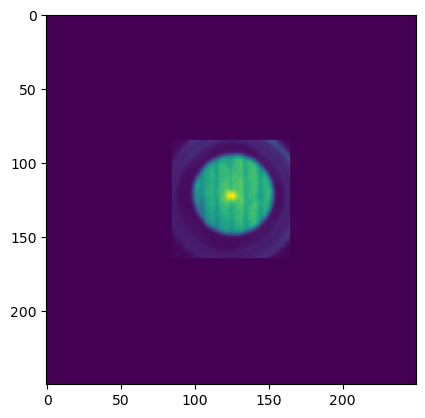

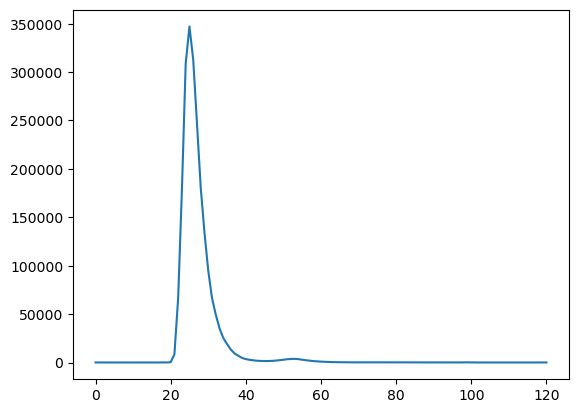

In [3]:

# %% get the sensitivity map and the IRF
data_fold = r'F:/OneDrive/UK_projects_local/project in UK 2024\diffuse_experiment241021/zhiguan_data/XL_measurement_061224'

#-----------------prepare the sensitibity map-------------
sens_path = os.path.join(data_fold,r'sensitivity_map_gain0.7_8x8cm_51x51points_binWidth15ps_expo0.1sec_binNum2000_40deg_061224.npy')
sensitivity = np.load(sens_path).sum(2)
sensitivity = sensitivity/sensitivity.max()
sensitivity = np.fliplr(sensitivity)
sensitivity = resize(sensitivity, (80,80), interpolation=cv2.INTER_LINEAR)
sens_pad = np.zeros((250,250))
sens_pad[125-40:125+40, 125-40:125+40] = sensitivity

plt.figure()
plt.imshow(sens_pad)
plt.show()

#-----------------prepare the IRF---------------------
IRF_path = os.path.join(data_fold,r'IRF_gain0.7_timebin15ps_2000bins_061224.npy')
IRF = np.load(IRF_path)[:1000]
IRF_down = resize(IRF[:np.round(121*100/15).astype('int')], (1, 121), interpolation=cv2.INTER_NEAREST_EXACT)
IRF_down= np.squeeze(IRF_down)
plt.plot(IRF_down)

sim_len = 121

src_x_positions = np.linspace(125+25,125-25,3) # from PMT view, from right to left
src_y_positions = np.linspace(125+25,125-25,3) # from PMT view, from up to down

#--------------MCX cfg------------------
try:
    cfg.clear()
except NameError:
    pass  
    
cfg = {'nphoton': 1e7, 
       'tstart':0, 
       
        'tend':sim_len*1e-10, 
        'tstep':0.1e-9, # 100 ps resolution
       'srcpos': [10,125,0], 
       'srcdir':[0,0,1],
       'unitinmm':1,
       # 'detpos': [125, 125, t_vox, 4], #radius approx 1mm (4vox) (fibre ~2mm from sample)
       'issrcfrom0':1,
       'issavedet':1,
       'issaveref':1
       }


cfg['prop'] = [[0,0,1,1],           # background
               [0.0019, 1.4800,0,1.44], # volume 1
               ]


## sim loop

In [ ]:
current_date = datetime.now().strftime("%d%m%y") 
save_dir = f'F:/OneDrive/foam_imaging_project/pmcx_foam/batch_mcx_sim_data/data_021225'
os.makedirs(save_dir, exist_ok=True)
gd_path = os.path.join(save_dir, 'ds_objs_50x50_5x5cm.npy')
sims_result_path = os.path.join(save_dir, 'batch_mcx_sims_results.npy')
checkpoint_json = os.path.join(save_dir, 'checkpoint.json')

total_count = NUM_TOTAL
save_interval = 100  # save every 100 sims

start_index = 0

# 1. check for existing checkpoint
if os.path.exists(checkpoint_json) and os.path.exists(gd_path) and os.path.exists(sims_result_path):
    print("found check point, reloading...")
    
    # redad checkpoint
    with open(checkpoint_json, 'r') as f:
        ckpt = json.load(f)
        start_index = ckpt['last_index'] + 1 # start from next index
        
    # load saved big data file (Loading to RAM)
    ground_truths = np.load(gd_path)
    sim_results = np.load(sims_result_path)
    
    print(f"successful loading, start from {start_index} ")
else:
    print("no checkpoint, restart...")
    start_index = 0
    ground_truths = np.zeros((50, 50, total_count), dtype=np.float32) # 
    sim_results = np.zeros((3, 3, sim_len, total_count), dtype=np.float32)

# ================= main loop =================
if start_index < total_count:

    display(disp_region)
    with disp_region:

        # range start from  start_index
        for img_index in tqdm(range(start_index, total_count), initial=start_index, total=total_count):

            # ---------------- start processing ----------------
            img, lab = subset_ds[img_index]  

            img = np.fliplr(np.rot90(img.squeeze(),k = -1,axes = (0,1))) 
            img = cv2.copyMakeBorder(
                img, top=2, bottom=2, left=2, right=2,  
                borderType=cv2.BORDER_CONSTANT, value=0   
            )
            
            img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_NEAREST)
            
            threshold = 0
            img[img<=threshold]=0
            img[img>threshold]=1
            img = 1-img
            
            #=============this if for the flipped MNIST dataset===================
            img = np.fliplr(img)
            #==============this is for the flipped MNIST dataset===================

            plt.figure()
            plt.imshow(img, cmap='gray')
            plt.show()
            
            # save ground_truths
            ground_truths[:,:,img_index] = img
        
            obj_in_mcx_PMT_padding = cv2.copyMakeBorder(
                img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=1
            )
            obj_in_mcx_PMT_padding = np.uint8(obj_in_mcx_PMT_padding)
            
            # MCX Volume setup
            thickness = 50 
            unitinmm = 1
            t_vox = int(thickness/unitinmm)
            vol = np.ones([250,250,t_vox+1],dtype='uint8')
            vol[:,:,-1] = 0
            vol[:,:,24] = np.rot90(obj_in_mcx_PMT_padding,k = -1,axes = (0,1)) 
            cfg['vol'] = vol

            sim_mea = np.zeros((3,3,sim_len))
            
            # Scanning loop
            for i, pos_y in enumerate(src_y_positions):
                for j, pos_x in enumerate(src_x_positions):
                    cfg['srcpos'] = [pos_x, pos_y, 0]
                    res = pmcx.run(cfg)
                    dref_bd = res['dref'][:,:,int(vol.shape[2]-1),:] 
                    dref_bd_rot = np.rot90(dref_bd, k=1, axes = (0,1)) 
                    sim_mea[i,j,:] = (dref_bd_rot*sens_pad[:,:,None]).sum((0,1)) 
                        
            sim_mea = np.apply_along_axis(lambda m: fftconvolve(m, IRF_down, mode='full'), axis=2, arr=sim_mea)[:,:,:sim_len]
            sim_mea = sim_mea/sim_mea.max()
            
            # 存入 sim_results
            sim_results[:,:,:,img_index] = sim_mea
            
            # ---------------- Checkpoint save ----------------
            # evert save_interval, or the last one
            if (img_index + 1) % save_interval == 0 or (img_index + 1) == total_count:
                print(f"\nCheckpoint: Saving data at index {img_index}...")
                
                # 1. save big data files (NumPy)
                np.save(gd_path, ground_truths)
                np.save(sims_result_path, sim_results)
                
                # 2. save checkpoint (JSON)
                with open(checkpoint_json, 'w') as f:
                    json.dump({'last_index': img_index}, f)
                    
                print("Saved.")

print("All Done!")


found check point, reloading...
successful loading, start from 1100 


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

## check the objs

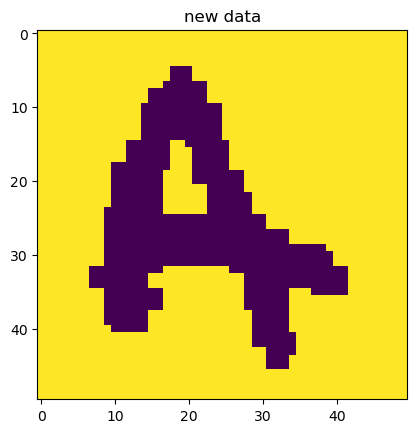

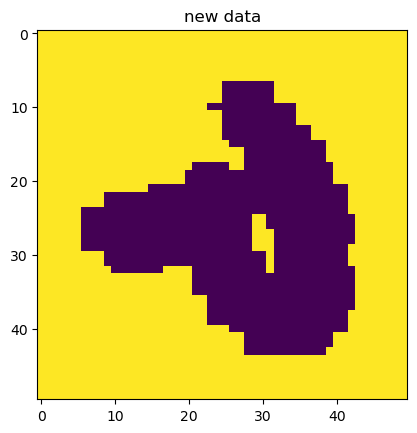

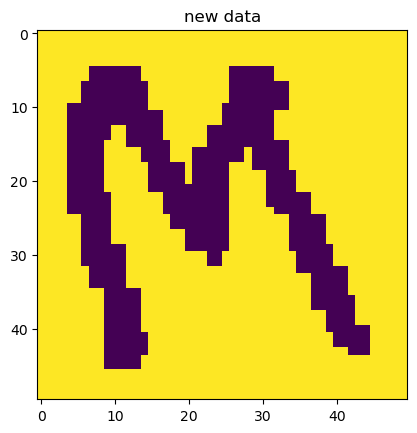

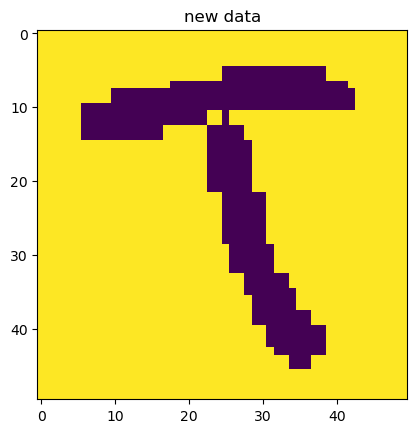

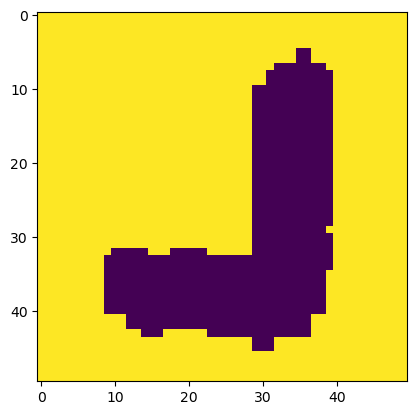

In [13]:
gd2 = np.load("F:/OneDrive/foam_imaging_project/pmcx_foam/batch_mcx_sim_data/data_021225/ds_objs_50x50_5x5cm.npy")
# gd1 = np.load("F:/OneDrive/foam_imaging_project/pmcx_foam/batch_mcx_sim_data/groundtruths.npy")

for i in range(0,2000,500):
    plt.figure()
    # plt.subplot(1,2,1)
    # plt.imshow(gd1[:,:,i])
    # plt.title('old data')
    # plt.show()
    # plt.subplot(1,2,2)
    plt.imshow(gd2[:,:,i])
    plt.title('new data')
    plt.show()

plt.figure()
plt.imshow(gd2[:,:,int(2000/26*12-20)])
plt.show()